# Deploying Super-resolution CNN

In [1]:
from __future__ import print_function, division
import scipy
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import keras.backend as K
from skimage.transform import resize
import nibabel as nib

/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def sr_cnn(patch_size = (None,None),nchannels = 1,n_residual_blocks = 16):
    def residual_block(layer_input):
        """Residual block"""
        d = Conv2D(64, kernel_size=3, strides=1, padding='same')(layer_input)
        d = Activation('relu')(d)
        d = BatchNormalization(momentum=0.8)(d)
        d = Conv2D(64, kernel_size=3, strides=1, padding='same')(d)
        d = BatchNormalization(momentum=0.8)(d)
        d = Add()([d, layer_input])
        return d

    def deconv2d(layer_input):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(256, kernel_size=3, strides=1, padding='same')(u)
        u = Activation('relu')(u)
        return u

    img_lr = Input(shape=(patch_size[0], patch_size[1],nchannels))
    # Pre-residual block
    c1 = Conv2D(64, kernel_size=9, strides=1, padding='same')(img_lr)
    c1 = Activation('relu')(c1)

    # Propogate through residual blocks
    r = residual_block(c1)
    for _ in range(n_residual_blocks - 1):
        r = residual_block(r)

    # Post-residual block
    c2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
    c2 = BatchNormalization(momentum=0.8)(c2)
    c2 = Add()([c2, c1])

    # Upsampling
    u1 = deconv2d(c2)

    # Generate high resolution output
    gen_hr = Conv2D(nchannels, kernel_size=9, strides=1, padding='same', activation='tanh')(u1)

    return Model(img_lr, gen_hr)

In [3]:
optimizer = Adam(0.0002, 0.5)
model = sr_cnn()
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.load_weights("../Data/sr_cnn.hdf5")

## CNN Results 2x

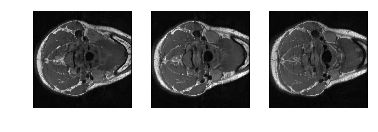

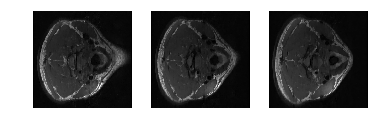

In [4]:
imgs_list = ["/media/roberto/DATA/GDrive/MR-Data/Carotid/Original-nifti/Djm__20130310182345_101_cca.nii.gz",\
             "/media/roberto/DATA/GDrive/MR-Data/Carotid/Original-nifti/Kmd__20130310143610_101_cca.nii.gz"]

for img in imgs_list:
    data = nib.load(img)
    affine = data.affine
    data_lr = data.get_data().transpose(2,0,1)
    #Normalization
    data_lr = 255.0*(data_lr-data_lr.min(axis=(1,2),keepdims = True))/(data_lr.max(axis=(1,2),keepdims = True)\
              -data_lr.min(axis=(1,2),keepdims = True))
    data_lr = data_lr/127.5 - 1.
    data_hr = model.predict(data_lr[:,:,:,np.newaxis],batch_size=8)[:,:,:,0]
    data_hr = ((data_hr + 1)*127.5)
    nifti = nib.Nifti1Image((data_hr).transpose(1,2,0), affine)
    nib.save(nifti,"../Data/SR-results/" + img.split("/")[-1].split(".")[0]+ "_sr_cnn_2x.nii.gz")
    plt.figure()
    plt.subplot(131)
    plt.imshow(data_hr[0,:,:],cmap = "gray")
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(data_hr[16,:,:],cmap = "gray")
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(data_hr[32,:,:],cmap = "gray")
    plt.axis("off")
    plt.show()

## CNN Results

/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/scikit_image-0.14.dev0-py2.7-linux-x86_64.egg/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


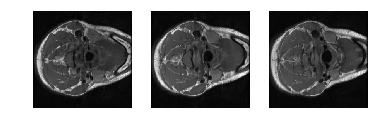

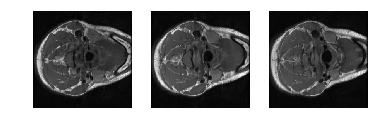

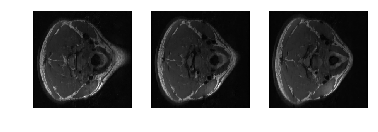

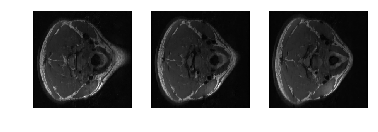

In [5]:
for img in imgs_list:
    data = nib.load(img)
    affine = data.affine
    data_hr = data.get_data().transpose(2,0,1)
    #Normalization
    data_hr = 255.0*(data_hr-data_hr.min(axis=(1,2),keepdims = True))/(data_hr.max(axis=(1,2),keepdims = True)\
              -data_hr.min(axis=(1,2),keepdims = True))
    data_lr = np.zeros((data_hr.shape[0],int(data_hr.shape[1]/2),int(data_hr.shape[2]/2)))
    for ii in xrange(data_lr.shape[0]):
        data_lr[ii] = resize(data_hr[ii],(int(data_hr.shape[1]/2),int(data_hr.shape[2]/2)),anti_aliasing = True)
    data_lr = data_lr/127.5 - 1.
    data_hr_pred = model.predict(data_lr[:,:,:,np.newaxis],batch_size=8)[:,:,:,0]
    data_hr_pred = ((data_hr_pred + 1)*127.5)
    nifti = nib.Nifti1Image((data_hr_pred).transpose(1,2,0), affine)
    nib.save(nifti,"../Data/SR-results/" + img.split("/")[-1].split(".")[0]+ "_sr_cnn.nii.gz")
    nifti = nib.Nifti1Image((data_lr).transpose(1,2,0), affine)
    nib.save(nifti,"../Data/SR-results/" + img.split("/")[-1].split(".")[0]+ "_lr.nii.gz")
    #LR
    plt.figure()
    plt.subplot(131)
    plt.imshow(data_hr[0,:,:],cmap = "gray")
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(data_hr[16,:,:],cmap = "gray")
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(data_hr[32,:,:],cmap = "gray")
    plt.axis("off")
    plt.show()
    #HR
    plt.figure()
    plt.subplot(131)
    plt.imshow(data_hr[0,:,:],cmap = "gray")
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(data_hr[16,:,:],cmap = "gray")
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(data_hr[32,:,:],cmap = "gray")
    plt.axis("off")
    plt.show()

## Interpolation Results

/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/scikit_image-0.14.dev0-py2.7-linux-x86_64.egg/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


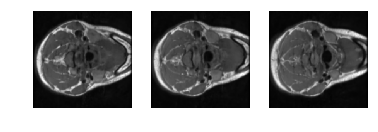

/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/scikit_image-0.14.dev0-py2.7-linux-x86_64.egg/skimage/transform/_warps.py:812: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  warn("Bi-quadratic interpolation behavior has changed due "


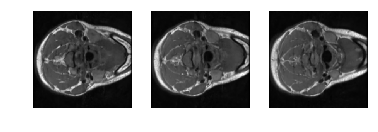

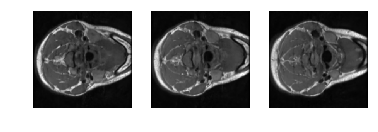

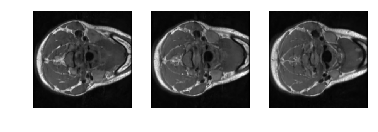

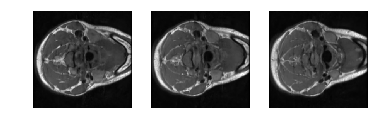

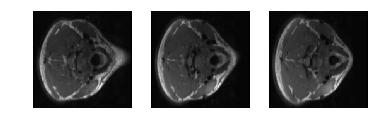

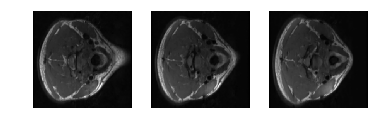

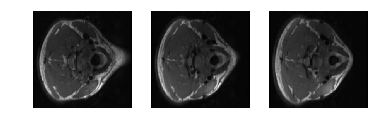

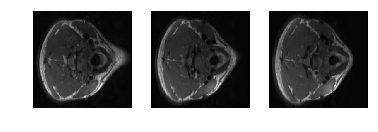

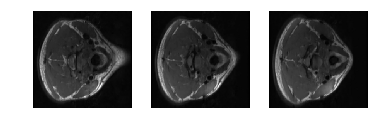

In [6]:
out_path = "/media/roberto/DATA/ML101/Data/SR-results"
ds = 2
for img in imgs_list:
    name = img.split("/")[-1].split(".")[0]
    data = nib.load(img)
    affine = data.affine
    data = data.get_data()
    data = data.transpose(2,0,1)
    data = (255.0*(data-data.min(axis=(1,2),keepdims = True))/(data.max(axis=(1,2),keepdims = True)\
                    -data.min(axis=(1,2),keepdims = True))).astype(np.uint8)
    nslices,H,W = data.shape
    data_lr = np.zeros((nslices,int(H/ds),int(W/ds)))
    for ii in xrange(nslices):
        data_lr[ii] = resize(data[ii],(H/ds,W/ds),anti_aliasing = True, preserve_range = True)
    for jj in xrange(1,6):
        data_aux = np.zeros((nslices,H,W))
        for kk in xrange(nslices):
            data_aux[kk] = resize(data_lr[kk],(H,W),order = jj, preserve_range = True)
        nifti = nib.Nifti1Image(data_aux.transpose(1,2,0).astype(np.uint8),affine)
        nib.save(nifti,os.path.join(out_path,name+"_spline_order" + str(jj) + ".nii.gz"))
        plt.figure()
        plt.subplot(131)
        plt.imshow(data_aux[0,:,:],cmap = "gray")
        plt.axis("off")
        plt.subplot(132)
        plt.imshow(data_aux[16,:,:],cmap = "gray")
        plt.axis("off")
        plt.subplot(133)
        plt.imshow(data_aux[32,:,:],cmap = "gray")
        plt.axis("off")
        plt.show()

## Interpolation Results 2x

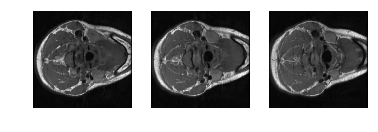

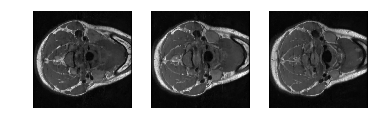

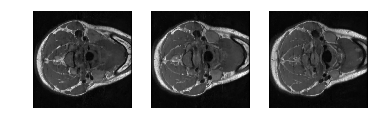

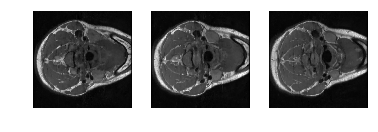

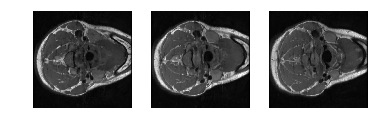

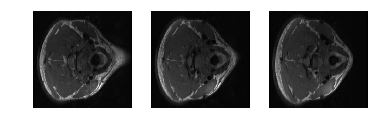

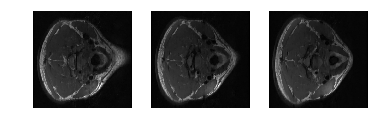

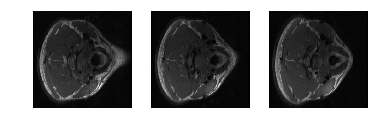

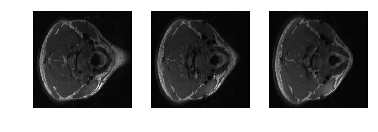

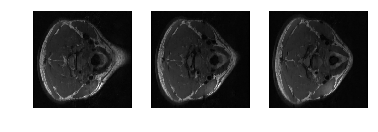

In [7]:
out_path = "/media/roberto/DATA/ML101/Data/SR-results"
ds = 2
for img in imgs_list:
    name = img.split("/")[-1].split(".")[0]
    data = nib.load(img)
    affine = data.affine
    data = data.get_data()
    data = data.transpose(2,0,1)
    nslices,H,W = data.shape
    data = (255.0*(data-data.min(axis=(1,2),keepdims = True))/(data.max(axis=(1,2),keepdims = True)\
            -data.min(axis=(1,2),keepdims = True))).astype(np.uint8)
    for jj in xrange(1,6):
        data_aux = np.zeros((nslices,2*H,2*W))
        for kk in xrange(nslices):
            data_aux[kk] = resize(data[kk],(2*H,2*W),order = jj, preserve_range = True)
        nifti = nib.Nifti1Image(data_aux.transpose(1,2,0).astype(np.uint8),affine)
        nib.save(nifti,os.path.join(out_path,name+"_spline_order" + str(jj) + "_2x.nii.gz"))
        plt.figure()
        plt.subplot(131)
        plt.imshow(data_aux[0,:,:],cmap = "gray")
        plt.axis("off")
        plt.subplot(132)
        plt.imshow(data_aux[16,:,:],cmap = "gray")
        plt.axis("off")
        plt.subplot(133)
        plt.imshow(data_aux[32,:,:],cmap = "gray")
        plt.axis("off")
        plt.show()